## Percolation

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams['animation.embed_limit'] = 2**128
from IPython import display
import numba
from concurrent import futures
import functools

In [2]:
n = 32
q = 0.3
A = (np.random.random(size = (n, n)) <= q).astype(int)
A[0] = 5
A

array([[5, 5, 5, ..., 5, 5, 5],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
n = 32
q = 0.63
A = (np.random.random(size = (n - 1, n)) <= q).astype(int)
A = np.vstack([[5]*n, A])
A

array([[5, 5, 5, ..., 5, 5, 5],
       [1, 1, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0]])

In [4]:
A.shape

(32, 32)

In [5]:
w = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
    ])

In [6]:
signal.correlate2d(A, w, mode='same')

array([[ 6, 11, 10, ..., 10, 11,  6],
       [ 6,  7,  7, ...,  8,  7,  6],
       [ 3,  3,  2, ...,  2,  2,  3],
       ...,
       [ 2,  3,  4, ...,  2,  3,  2],
       [ 3,  4,  2, ...,  2,  2,  1],
       [ 2,  2,  3, ...,  1,  0,  1]])

In [7]:
A == 1

array([[False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False,  True,  True],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False]])

In [8]:
c = signal.correlate2d(A, w, mode='same')
c

array([[ 6, 11, 10, ..., 10, 11,  6],
       [ 6,  7,  7, ...,  8,  7,  6],
       [ 3,  3,  2, ...,  2,  2,  3],
       ...,
       [ 2,  3,  4, ...,  2,  3,  2],
       [ 3,  4,  2, ...,  2,  2,  1],
       [ 2,  2,  3, ...,  1,  0,  1]])

In [9]:
A[(A==1)&(c>=5)]=5
A

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 0, ..., 0, 5, 5],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0]])

In [10]:
def paso_percolacion(A):
    c = signal.correlate2d(A, w, mode='same')
    A[(A==1)&(c>=5)]=5

In [11]:
def actualizar_animacion(i):
    if i < 0:
        return 
    global A
    paso_percolacion(A)
    imagen.set_array(A)

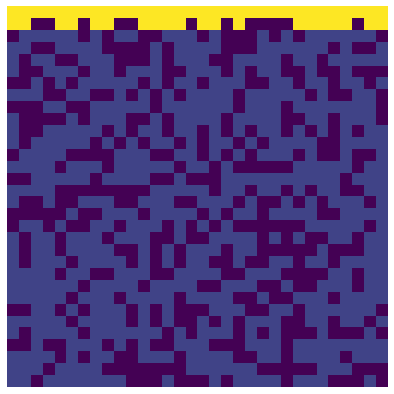

In [12]:
# crear figura
fig, ax = plt.subplots(figsize=(7,7))
ax.set_axis_off()
imagen = ax.imshow(A)

In [13]:
anim = animation.FuncAnimation(fig, actualizar_animacion)

In [14]:
display.display_html(anim.to_jshtml(), raw=True)

Once 
 
 Loop 
 
 Reflect

Once 
 
 Loop 
 
 Reflect

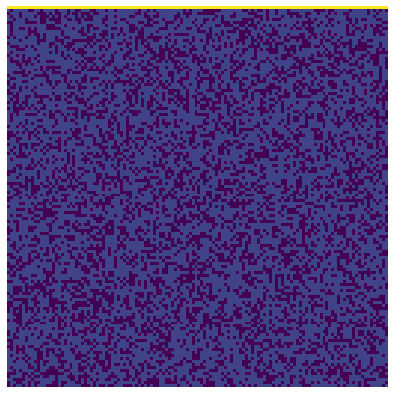

In [15]:
n = 128
q = 0.62

w = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
    ])

def paso_percolacion(A, w):
    c = signal.correlate2d(A, w, mode='same')
    A[(A==1)&(c>=5)]=5
    
def actualizar_animacion(i):
    global A
    if i == 0:
        A = (np.random.random(size = (n - 1, n)) <= q).astype(int)
        A = np.vstack([[5]*n, A])
    else:
        c = signal.correlate2d(A, w, mode='same')
        A[(A==1)&(c>=5)]=5
    imagen.set_array(A)
    
# crear figura
fig, ax = plt.subplots(figsize=(7,7))
ax.set_axis_off()
imagen = ax.imshow(A, vmin=0, vmax=5)
    
anim = animation.FuncAnimation(fig, actualizar_animacion, frames=2*n-1, interval=1000/24)
display.display_html(anim.to_jshtml(), raw=True)

In [16]:
w = np.array([
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0]
    ])

def simular_percolacion(n, q, w=w):
    A = (np.random.random(size = (n - 1, n)) <= q).astype(np.int_)
    A = np.vstack([[5]*n, A])
    while True:
        c = signal.correlate2d(A, w, mode='same')
        cambio = (A==1)&(c>=5)
        if np.all(~cambio):
            return False
        A[cambio]=5
        if np.any(A[n-1]==5):
            return True

In [17]:
simular_percolacion(128, .6)

True

In [18]:
def probabilidad_grupo_percolacion(n, q, w=w, iters=1000):
    func = functools.partial(simular_percolacion, q=q, w=w)
    with futures.ProcessPoolExecutor(max_workers=8) as ejecutor:
        resultados = list(ejecutor.map(func, [n]*iters, chunksize=iters//20))
    return sum(resultados)/iters

In [19]:
probabilidad_grupo_percolacion(128,.6)

0.66

In [ ]:
lista_q = np.linspace(0.55, 0.65, num=50)
probabilidades = [probabilidad_grupo_percolacion(64, q) for q in lista_q]
fig, ax = plt.subplots()
ax.plot(lista_q, probabilidades)